# Load Libraries

In [ ]:
# dl packages
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# ml packages
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud


# Load data

In [ ]:
train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")
# get all words length in comment
train_data['length'] = [len(x) for x in train_data['Comment']]

In [ ]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59


In [ ]:
train_data.shape

(16000, 3)

In [ ]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [ ]:
train_data.duplicated().sum()

1

# EDA

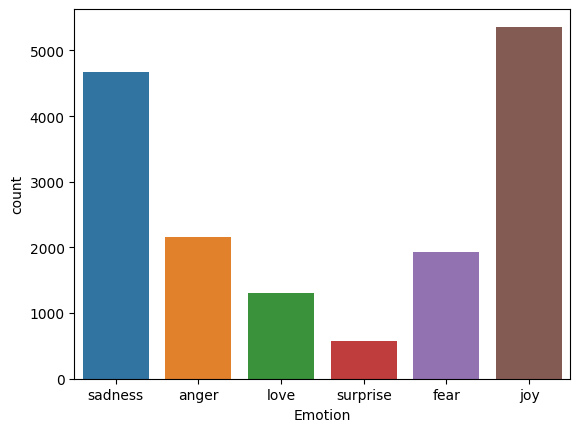

In [ ]:
sns.countplot(x = train_data['Emotion'])
plt.show()

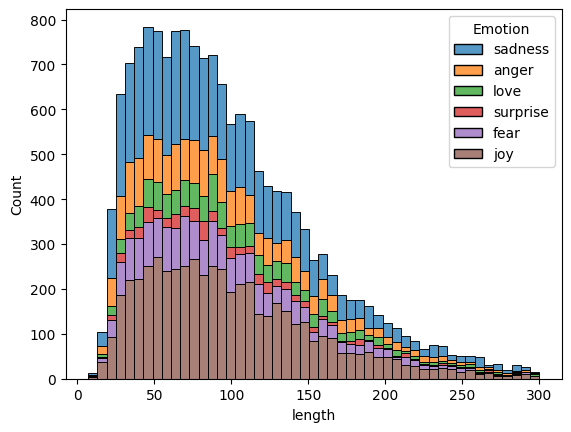

In [ ]:
# data distribution
df2 = train_data.copy()
df2['length'] = [len(x) for x in df2['Comment']]

# Convert the 'length' column to a numpy array
length_values = df2['length'].values

# Use sns.histplot instead of sns.kdeplot for simplicity
sns.histplot(data=df2, x='length', hue='Emotion', multiple='stack')

plt.show()

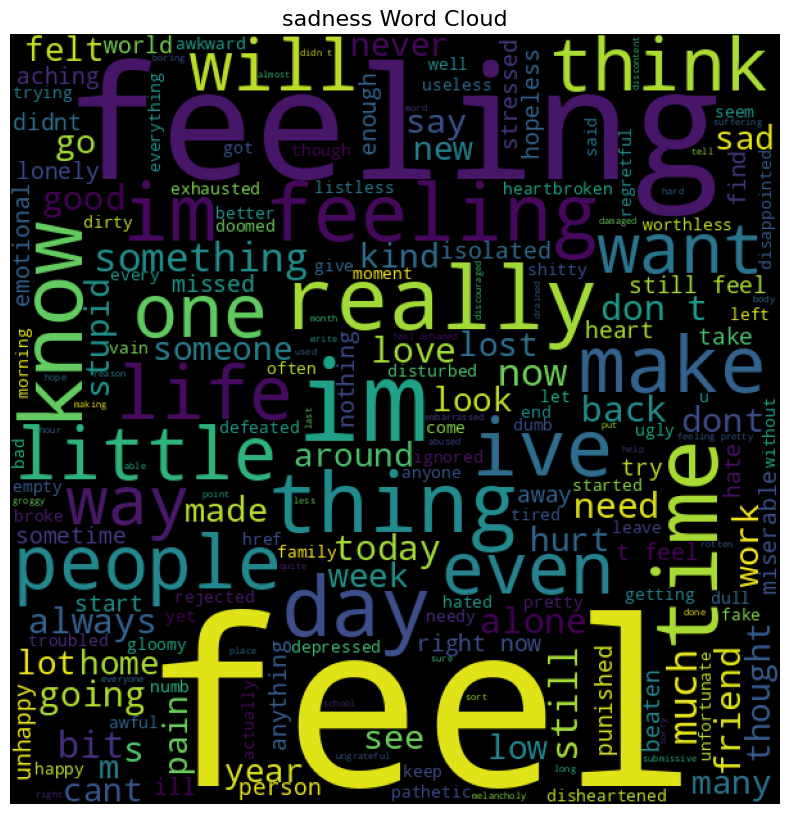

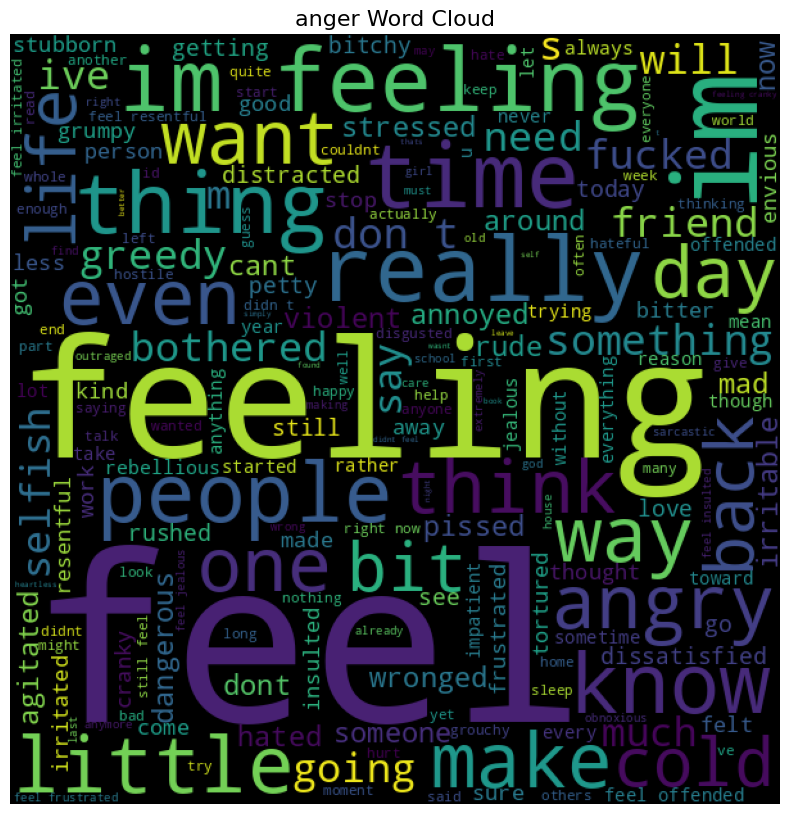

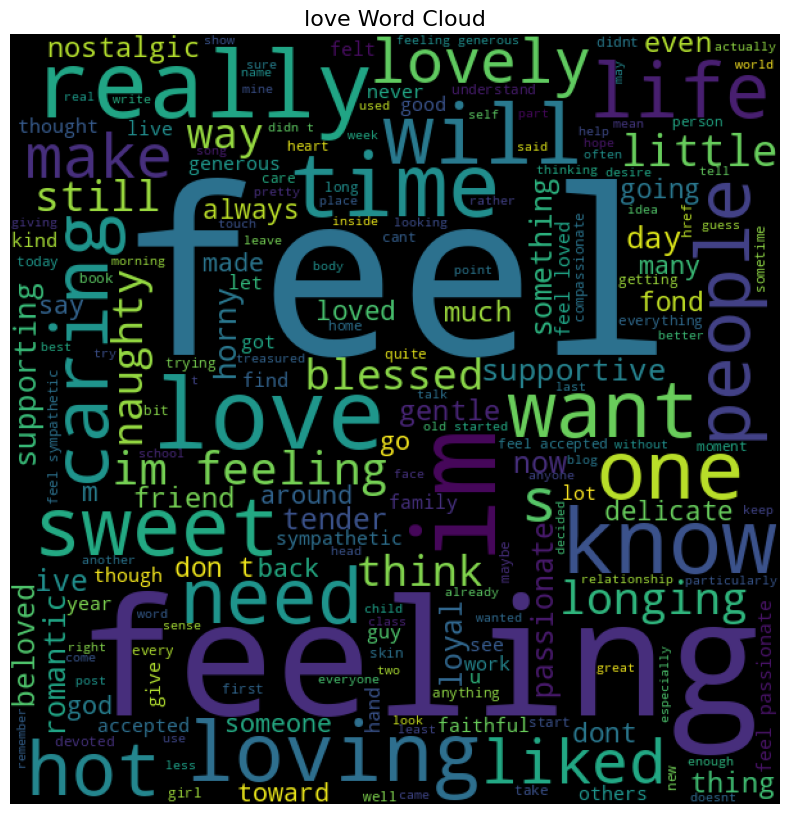

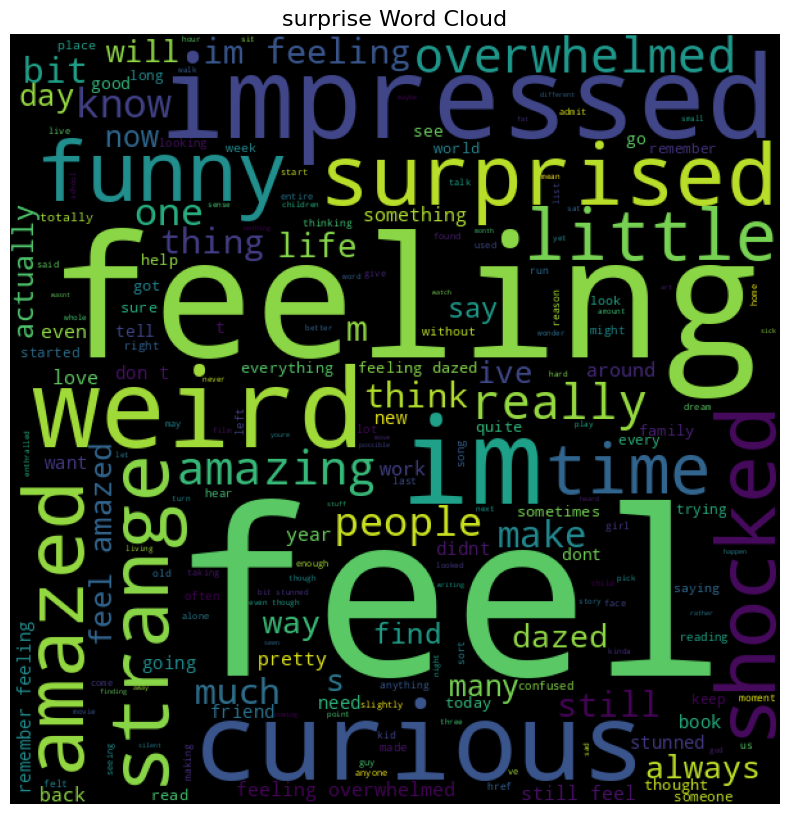

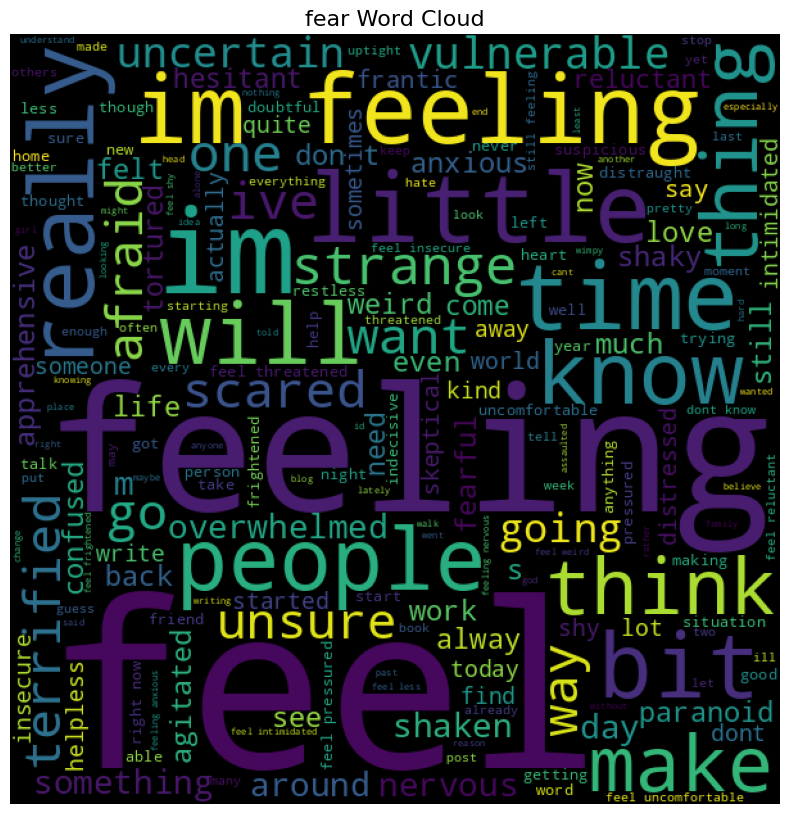

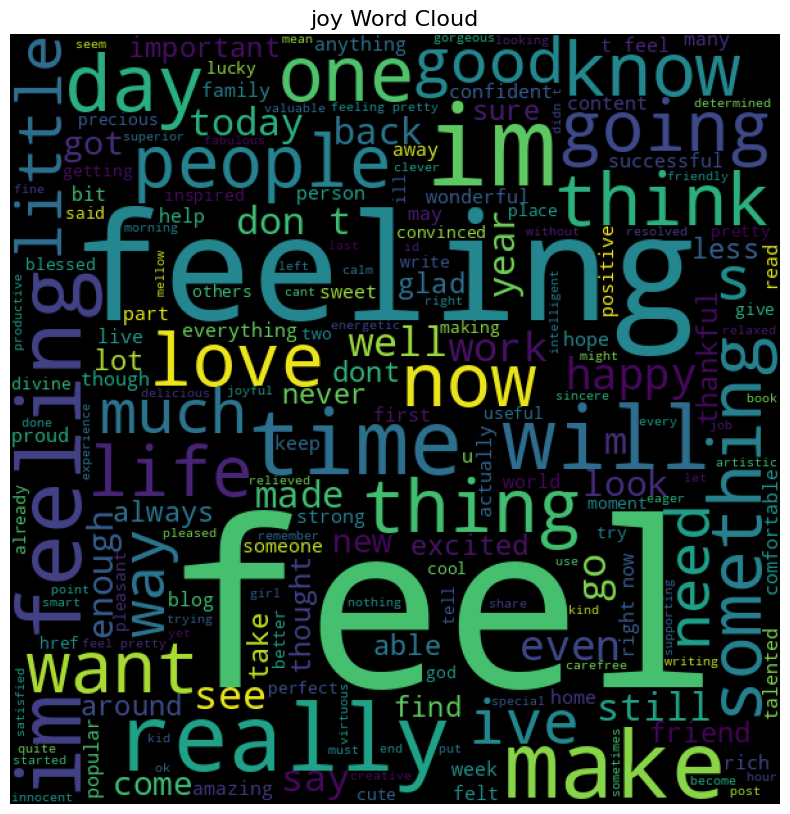

In [ ]:
# Words cloud for each emotions
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud)
    # No axis details
    plt.axis("off");
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

# Data Preprocessing
# Encode emotions

In [ ]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [ ]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


# Applying Machine Learning

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
df = train_data.copy() # copy df from train_data because we will use this for deep learing next

In [ ]:
df

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


In [ ]:
# Data cleaning and preprocessing
# Download NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment'] = df['Comment'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'],df['Emotion'],test_size=0.2,random_state=42)

In [ ]:
X_train

676      refer cours though cant help feel somehow iron...
12113                       im start feel im suffer fatigu
7077     feel like probabl would like book littl bit si...
13005                                  realli feel awkward
12123    im feel littl grumpi today lame weather teas g...
                               ...                        
13418         love leav reader feel confus slightli deceiv
5390                                            feel delic
860                                start feel littl stress
15795                  feel stress tire worn shape neglect
7270             feel someon rude wrongli done someth lose
Name: cleaned_comment, Length: 12800, dtype: object

In [ ]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
X_train_tfidf

<12800x9257 sparse matrix of type '<class 'numpy.float64'>'
	with 115139 stored elements in Compressed Sparse Row format>

In [ ]:
# Multi-class classification using different algorithms
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
}

for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"\nAccuracy using TF-IDF: {accuracy_tfidf}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_tfidf))


===== Multinomial Naive Bayes =====

Accuracy using TF-IDF: 0.655
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.31      0.46       427
           1       0.91      0.24      0.38       397
           2       0.58      0.98      0.73      1021
           3       1.00      0.03      0.06       296
           4       0.70      0.91      0.79       946
           5       1.00      0.01      0.02       113

    accuracy                           0.66      3200
   macro avg       0.85      0.41      0.41      3200
weighted avg       0.76      0.66      0.58      3200


===== Logistic Regression =====


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy using TF-IDF: 0.829375
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       427
           1       0.84      0.73      0.78       397
           2       0.78      0.94      0.85      1021
           3       0.80      0.49      0.61       296
           4       0.88      0.92      0.90       946
           5       0.77      0.45      0.57       113

    accuracy                           0.83      3200
   macro avg       0.82      0.72      0.76      3200
weighted avg       0.83      0.83      0.82      3200


===== Random Forest =====

Accuracy using TF-IDF: 0.851875
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       427
           1       0.84      0.84      0.84       397
           2       0.84      0.90      0.87      1021
           3       0.81      0.63      0.71       296
           4       0.91      0.90      0.90    

In [ ]:
# selecting model
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
lg_y_pred = lg.predict(X_test_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
lg_y_pred

array([4, 2, 4, ..., 2, 2, 4])

In [ ]:
def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Predict emotion
    predicted_label = lg.predict(input_vectorized)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label =  np.max(lg.predict(input_vectorized))

    return predicted_emotion,label

# Example usage
sentences = [
            "I will always be loving you",
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    pred_emotion, label = predict_emotion(sentence)
    print("Prediction :",pred_emotion)
    print("Label :",label)
    print("================================================================")

I will always be loving you
Prediction : love
Label : 3
i feel strong and good overall
Prediction : joy
Label : 2
im grabbing a minute to post i feel greedy wrong
Prediction : anger
Label : 0
He was speechles when he found out he was accepted to this new job
Prediction : joy
Label : 2
This is outrageous, how can you talk like that?
Prediction : anger
Label : 0
I feel like im all alone in this world
Prediction : sadness
Label : 4
He is really sweet and caring
Prediction : love
Label : 3
You made me very crazy
Prediction : sadness
Label : 4
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Prediction : love
Label : 3
i am feeling grouchy
Prediction : anger
Label : 0
He hates you
Prediction : anger
Label : 0


##  Save files

In [ ]:
import pickle
pickle.dump(lg,open("logistic_regresion.pkl",'wb'))
pickle.dump(lb,open("label_encoder.pkl",'wb'))
pickle.dump(tfidf_vectorizer,open("tfidf_vectorizer.pkl",'wb'))